# M4 Time Series and EOFs

In this notebook I will explore long time series climatology data and do some statistical analysis. 

Some parts of this notebook follow this work: (https://climate.usu.edu/people/yoshi/pyclm101/monthly.html)

Here are some modules requirement:
- `eofs`
- `stasmodels`

### 1. Create a dataset of SST and Prec. Anomalies 

In [2]:
# load the needed modules

import warnings
import xarray as xr
import pandas as pd
import numpy as np
import s3fs
import fsspec
import netCDF4
import zarr
import scipy
import matplotlib as mpl
import statsmodels as sm
import tensorflow as tf
import collections
import dask
collections.Iterable = collections.abc.Iterable

from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from dateutil.parser import parse
from eofs.xarray import Eof
from eofs.examples import example_data_path

In [2]:
# load the dataset for sst

base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url2 = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)

In [3]:
# load sst data

ds_sst = xr.open_mfdataset(file_list, parallel=True)

# load the land mask data

lsm = xr.open_dataset('https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc',
                      engine='netcdf4')



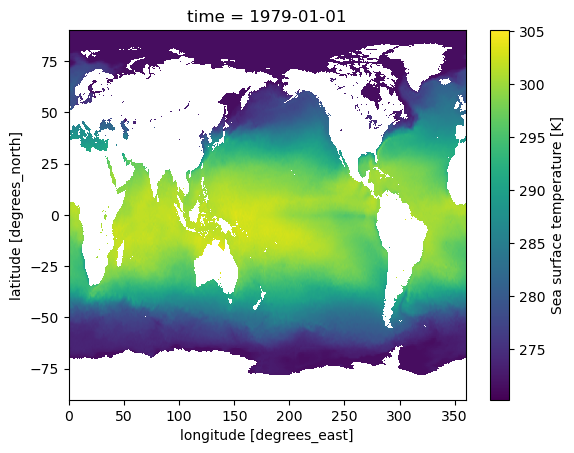

In [4]:
# to check the data by plotting them

check_sst = ds_sst.isel(time=0)

check_sst['SSTK'].plot()

In [5]:
# only selected the required area

sst_sel = ds_sst.sel(latitude=slice(65,-65), longitude=slice(120, 360-60))

sst_sel

<xarray.Dataset>
Dimensions:    (latitude: 521, longitude: 721, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 dask.array<chunksize=(12,), meta=np.ndarray>
    SSTK       (time, latitude, longitude) float32 dask.array<chunksize=(12, 521, 721), meta=np.ndarray>
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 07:46:57 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 07:46:58 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [6]:
# calculate the sst anomaly

month_sst = sst_sel.groupby('time.month')
sst_anom = month_sst - month_sst.mean(dim='time')
sst_anom

/data/keeling/a/fsari2/miniconda3/envs/py3/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:    (latitude: 521, longitude: 721, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    utc_date   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    SSTK       (time, latitude, longitude) float32 dask.array<chunksize=(1, 521, 721), meta=np.ndarray>

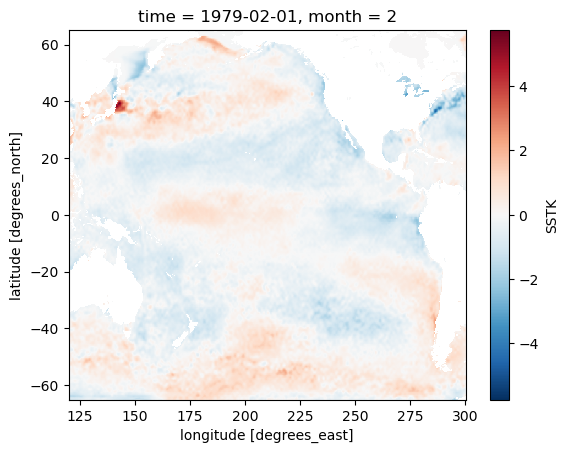

In [7]:
# check the anomaly sst data by poltting them 

check_anom_sst = sst_anom.isel(time=1)
check_anom_sst['SSTK'].plot()

In [ ]:
# save the anomaly sst 

data_dir = '/data/keeling/a/fsari2/a/ATMS523/data'

# filename
fname = '/sst_1979-2021_anom.nc'
sst_anom.to_netcdf(data_dir + fname)

In [46]:
# get precip. data from RDA UCAR

import xarray as xr
import pandas as pd

base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.meanflux/'
base_url2 = '/e5.moda.fc.sfc.meanflux.235_030_mcpr.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)


import xarray as xr
ds_cpr = xr.open_mfdataset(file_list, parallel=True, engine='netcdf4').\
    sel(longitude=slice(120.,360.-60.), latitude=slice(65.,-65.))

import pandas as pd

base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.meanflux/'
base_url2 = '/e5.moda.fc.sfc.meanflux.235_029_mlspr.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)

ds_lspr = xr.open_mfdataset(file_list, parallel=True, engine='netcdf4').\
    sel(longitude=slice(120.,360.-60.), latitude=slice(65.,-65.))

ds_pr = ds_lspr['MLSPR'] + ds_cpr['MCPR']

# check the loaded data

ds_pr

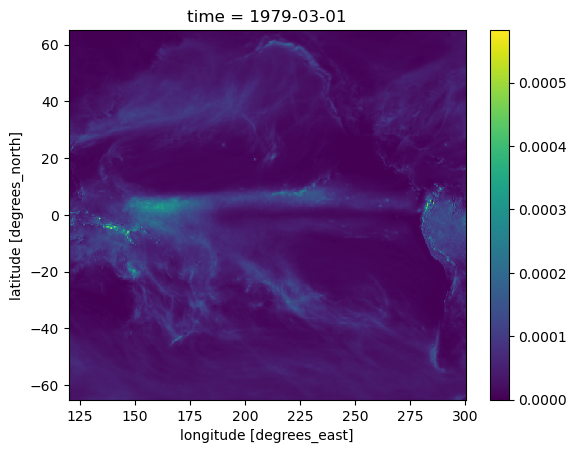

In [48]:
# to check the data by plotting them

check_pr = ds_pr.isel(time=2)

check_pr.plot()

In [ ]:
# calculate the anomaly of precip. data

month_pr = ds_pr.groupby('time.month')
pr_anom = month_pr - month_pr.mean(dim='time')
pr_anom

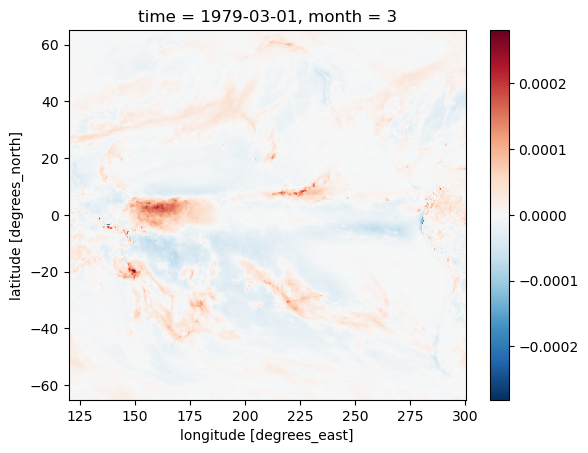

In [50]:
# to check the anomaly data

check_anom_pr = pr_anom.isel(time=2)
check_anom_pr.plot()

In [51]:
# save the dataset anomalies of precip. to netcdf file on local computer

# save the anomaly prec. dataset from rda

data_dir = '/data/keeling/a/fsari2/a/ATMS523/data'

# filename
fname = '/pr_1979-2021_anom.nc'
pr_anom.to_netcdf(data_dir + fname)

### 2. Deseasonalize, detrend and standardize the SST anomalies. 

In [3]:
# open the saved SST anomalies dataset and 
# the anomalies was already in the deg-C as they are a product of substraction

data_dir = '/data/keeling/a/fsari2/a/ATMS523/data'

sst = xr.open_dataset(data_dir + '/sst_1979-2021_anom.nc')

# see the loaded data

sst

<xarray.Dataset>
Dimensions:    (longitude: 721, latitude: 521, time: 516)
Coordinates:
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 ...
Data variables:
    utc_date   (time) float64 ...
    SSTK       (time, latitude, longitude) float32 ...

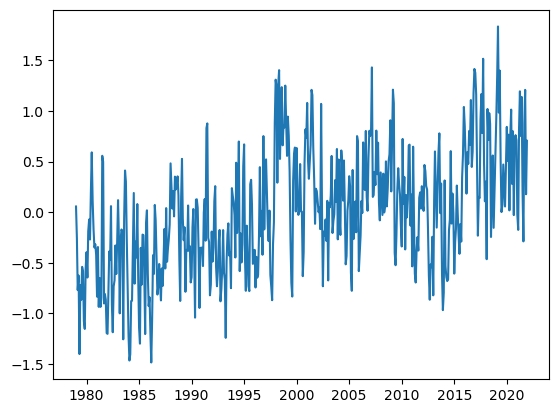

In [5]:
# to check the the sst anomalies dataset

check_sst_ts = sst.sel(latitude=30, longitude=130, method="nearest")
plt.plot(check_sst_ts['time'], check_sst_ts['SSTK'])

In [4]:
# deseasonalize monthly means SST anomalies

month_mean_anom_sst = sst.groupby('time.month').mean('time')
des_anom_sst = sst.groupby('time.month') - month_mean_anom_sst

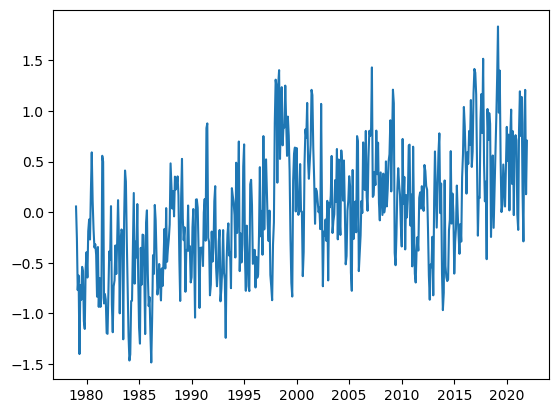

In [7]:
# to check the deseasonlize monthly means SST anomalies

check_des_sst_ts = des_anom_sst.sel(latitude=30, longitude=130, method="nearest")
plt.plot(check_des_sst_ts['time'], check_des_sst_ts['SSTK'])

In [ ]:
# function code to detrend the SST anomalies

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# get a detrend data

det_anom_sst = detrend_dim(des_anom_sst['SSTK'],'time',1)

# check teh detrend SST anomlies data

det_anom_sst

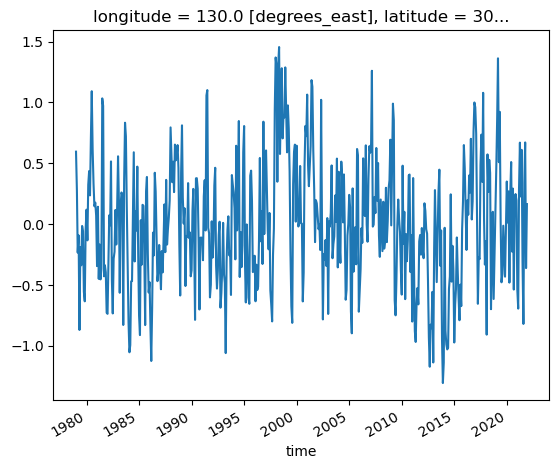

In [9]:
# to check the detrend monthly means SST anomalies

check_det_sst_ts = det_anom_sst.sel(latitude=30, longitude=130, method="nearest")
check_det_sst_ts.plot()

In [ ]:
# standardize the anomalies data
# her ewe use dataset after applying detrend process

month_mean_anom_sst = det_anom_sst.groupby('time.month').mean('time')
month_std_anom_sst = det_anom_sst.groupby('time.month').std('time')
stand_anom_sst = xr.apply_ufunc(
                                  lambda x, m, s: (x - m) / s,
                                  det_anom_sst.groupby('time.month'),
                                  month_mean_anom_sst, month_std_anom_sst)

# to check the result whether it has same dimensions

stand_anom_sst

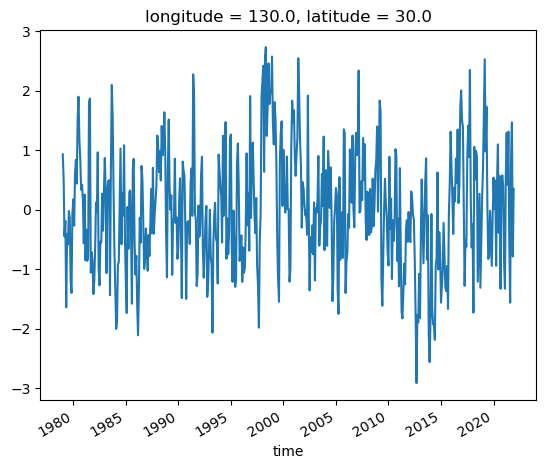

In [12]:
# to check the standardize monthly means SST anomalies

check_std_sst_ts = stand_anom_sst.sel(latitude=30, longitude=130, method="nearest")
check_std_sst_ts.plot()

### 3. Perform an EOF with weighting consideration

In [ ]:
# changet the structure of SST anomalies dataset into data array 

stand_sst = stand_anom_sst.to_dataset(name='standardize_anom_sst')
stand_sst = stand_sst.standardize_anom_sst

# check the data

stand_sst

In [8]:
# drop the added coordinates 

stand_sst = stand_sst.drop("month")


In [ ]:
# to check the data before performing EOF analysis

stand_sst

In [10]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.

coslat = np.cos(np.deg2rad(stand_sst.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(stand_sst, weights=wgts)

In [11]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=10)
pc1 = solver.pcs(npcs=10, pcscaling=1)

Text(0.45, 1.0, 'The First 5 EOFs Expressed as Correlation')

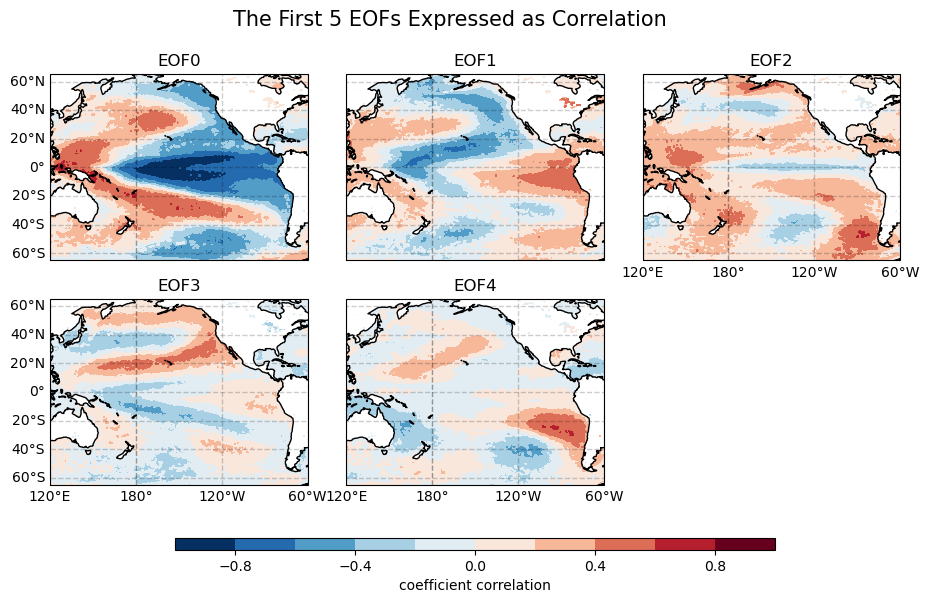

In [88]:
# plot the first 5 EOFs

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

eof_sst = [eof1.isel(mode=i) for i in range (5)]

proj = ccrs.PlateCarree(central_longitude = 190)
fig, axes = plt.subplots(
    2, 3, figsize=(10, 6), 
    subplot_kw={'projection': proj, 
    "aspect": 1},
)
clevs = np.linspace(-1, 1, 11)

for i, (img, ax) in enumerate(zip(eof_sst,[y for x in axes for y in x])):

    plot_eof_sst = img.plot.contourf(
        ax=ax, levels=clevs, 
        transform=ccrs.PlateCarree(), 
        cmap=plt.cm.RdBu_r, 
        add_colorbar=False,
    )
    ax.set_title("EOF"+ str(img.mode.to_dict()["data"]))
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.2, linestyle="--")

    gl.xlocator = LongitudeLocator()
    gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    
    if i>= 2:
        gl.bottom_labels = True
    if i == 0 or i == 3:
        gl.left_labels = True

# delete unwanted figures
fig.delaxes(axes[1][2])

# adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.05, right=0.9,
                    wspace=0.15, hspace=0.15)

# add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.175, 0.1, 0.6, 0.02]) #left, bottom, width, height

# draw the colorbar
cbar=fig.colorbar(plot_eof_sst, cax=cbar_ax, orientation='horizontal')
cbar.set_label('coefficient correlation')

# add a big title at the top
plt.suptitle("The First 5 EOFs Expressed as Correlation", x= 0.45, y=1.0, fontsize = 15)


### 4. Plot the percent of variance explained by the first 10 EOFs.

In [12]:
# calculate the variance

varfrac = solver.varianceFraction()

(1.4994331138248915e-31, 20.006352398852254)

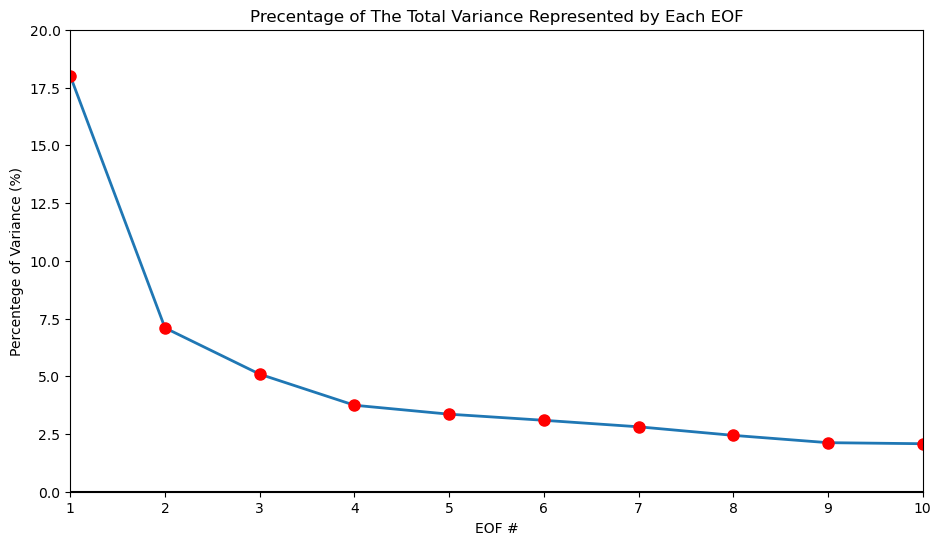

In [90]:
# plot the percent of variance explained by each EOF

plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10]*100, linewidth=2)
plt.plot(eof_num, varfrac[0:10]*100, linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Precentage of The Total Variance Represented by Each EOF')
plt.xlabel('EOF #')
plt.ylabel('Percentege of Variance (%)')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac*100), np.max(varfrac*100)+2)

### 5. Reconstruct the SST using the first 5 EOFs

In [ ]:
# calculate the reconstruction SST from SST anomlaies

rec_sst = solver.reconstructedField(5)

# check the result

rec_sst

In [ ]:
# calculate correlation both for recontructed and observed SST anomalies

corr_both = xr.corr(rec_sst, sst['SSTK'], dim="time")

# check the correlation 

corr_both

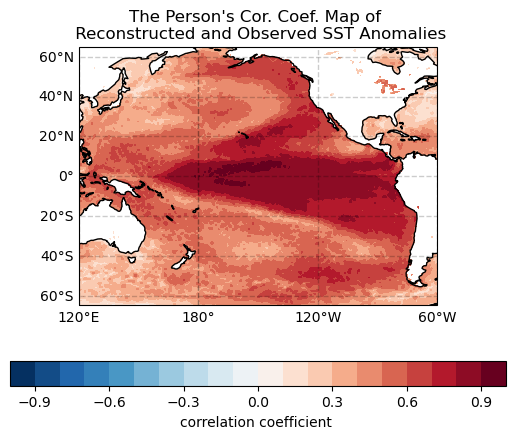

In [27]:
# plot map of correlation between recontructed and observed SST anomalies

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

clevs = np.linspace(-1, 1, 21)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))

sst_map = corr_both.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax.set_title('The Person\'s Cor. Coef. Map of \n Reconstructed and Observed SST Anomalies', fontsize=12)

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.2, linestyle="--")

gl.xlocator = LongitudeLocator()
gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.bottom_labels = True
gl.left_labels = True

cb = plt.colorbar(sst_map, orientation='horizontal')
cb.set_label('correlation coefficient ', fontsize=10)


### 6. Compute a map of Person's Corr. Between SST Anom EOF1 and Calculated Prec.

In [ ]:
# open precipitation anomalies dataset 


data_dir = '/data/keeling/a/fsari2/a/ATMS523/data'

pr = xr.open_dataset(data_dir + '/pr_1979-2021_anom.nc')

# see the loaded data

pr

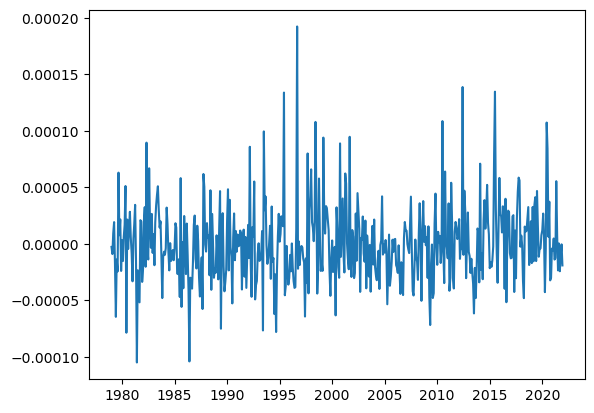

In [65]:
# to check the the precip anomalies dataset

check_pr_ts = pr.sel(latitude=30, longitude=130, method="nearest")
plt.plot(check_pr_ts['time'], check_pr_ts['__xarray_dataarray_variable__'])

In [ ]:
# as we already have function of detrend so we just need to recall it 
# for the precip. anomalies datases

det_anom_pr = detrend_dim(pr['__xarray_dataarray_variable__'],'time',1)

# check the detrend precip. anomlies data

det_anom_pr

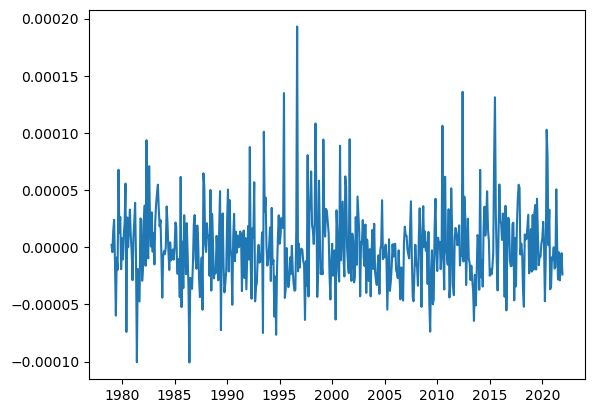

In [69]:
# deseasonal the dterended precip. anomalies data 

des_anom_pr = det_anom_pr.groupby('time.month') \
                - (det_anom_pr.groupby('time.month').mean(dim='time'))

# check result of deseasonal precip. anomalies 

check_des_pr_ts = des_anom_pr.sel(latitude=30, longitude=130, method="nearest")
plt.plot(check_des_pr_ts['time'], check_des_pr_ts)

In [70]:
# standardize the deseasonlised precipitation anomalies dataset

month_mean_anom_pr = des_anom_pr.groupby('time.month').mean('time')
month_std_anom_pr = des_anom_pr.groupby('time.month').std('time')
stand_anom_pr = xr.apply_ufunc(
                                  lambda x, m, s: (x - m) / s,
                                  des_anom_pr.groupby('time.month'),
                                  month_mean_anom_pr, month_std_anom_pr)

# to check the result whether it has same dimensions

stand_anom_pr

# to remove unwanted "month" dimension

stand_anom_pr = stand_anom_pr.drop("month")

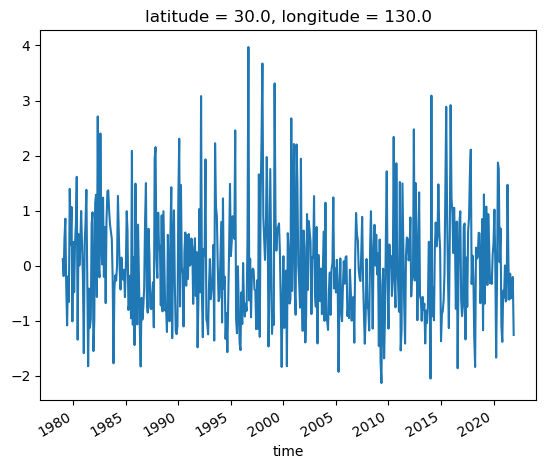

In [71]:
# to check the standardize monthly means precip. anomalies

check_std_pr_ts = stand_anom_pr.sel(latitude=30, longitude=130, method="nearest")
check_std_pr_ts.plot()

In [ ]:
# calculate the reconstructed SST only for the first EOFs

rec_sst_eof1 = solver.reconstructedField(1)

# check the result

rec_sst_eof1

In [ ]:
# calculate correlation both for recontructed SST anomalies (EOF 1) and precip. anomalies

corr_sst_pr = xr.corr(rec_sst_eof1, stand_anom_pr, dim="time")

# check the correlation 

corr_sst_pr

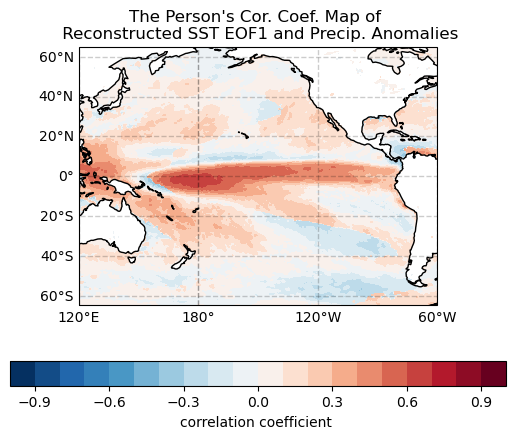

In [110]:
# plot map of correlation between recontructed and observed SST anomalies

clevs = np.linspace(-1, 1, 21)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))

sst_prec_map = corr_sst_pr.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax.set_title('The Person\'s Cor. Coef. Map of \n Reconstructed SST EOF1 and Precip. Anomalies', fontsize=12)

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.2, linestyle="--")

gl.xlocator = LongitudeLocator()
gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.bottom_labels = True
gl.left_labels = True

cb = plt.colorbar(sst_prec_map, orientation='horizontal')
cb.set_label('correlation coefficient ', fontsize=10)